In [1]:
from mfglib.env import Environment
from mfglib.alg.utils import _ensure_free_tensor,tuple_prod
from mfglib.mean_field import mean_field
from typing import Literal, cast
import torch
from mfglib.alg.greedy_policy_given_mean_field import Greedy_Policy
import matplotlib.pyplot as plt
from mfglib.alg import MFOMO,PriorDescent, FictitiousPlay,OnlineMirrorDescent, TwoScaleLearning
from mfglib.metrics import exploitability_score
from mfglib.alg.q_fn import QFn
import scipy

c:\Users\minghuiw\AppData\Local\anaconda3\envs\mfg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cal_diff(mu0, mu1):
    #return torch.sum((mu0-mu1)**2)
    if len(mu0.shape) == 1:
        return torch.sum(torch.abs(mu0-mu1))
    else:
        return torch.max(torch.sum(abs(mu0-mu1), axis=1))

In [ ]:
env_instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
solns, expls, runtimes = FictitiousPlay().solve(env_instance, max_iter=5000, verbose=True)
plt.semilogy(runtimes, exploitability_score(env_instance, solns)) 

plt.grid(True)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Exploitability")
plt.title("Rock Paper Scissors Environment - MFOMO Algorithm")
plt.show()

torch.Size([10, 3])
            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(10,)
	A(3,)
	T=3
	r_max=10

Algorithm summary:
	OnlineMirrorDescent(alpha=1.0)
	atol=0.001
	rtol=0.001
	max_iter=5000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 1.74481  |     1.00000     |          0           |  0.000   |
|  1   | 0.45661  |     0.26170     |          1           |  0.000   |
|  2   | 0.25793  |     0.14782     |          2           |  0.000   |
|  3   | 0.20866  |     0.11959     |          3           |  0.000   |
|  4   | 0.18953  |     0.10863     |          4           |  0.000   |
|  5   | 0.17459  |     0.10006     |          5           |  0.000   |
|  6   | 0.16156  |     0.09259     |      

ValueError: not enough values to unpack (expected 5, got 3)

torch.Size([10, 3])
            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(10,)
	A(3,)
	T=3
	r_max=10

Algorithm summary:
	OnlineMirrorDescent(Q_speed=0.6, mu_speed=1.0)
	atol=0.001
	rtol=0.001
	max_iter=5000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 1.74481  |     1.00000     |          0           |  0.000   |
|  1   | 0.77003  |     0.44132     |          1           |  0.009   |
|  2   | 0.41577  |     0.23829     |          2           |  0.012   |
|  3   | 0.28036  |     0.16068     |          3           |  0.020   |
|  4   | 0.24204  |     0.13872     |          4           |  0.023   |
|  5   | 0.23895  |     0.13695     |          5           |  0.026   |
|  6   | 0.25406  |     0.1

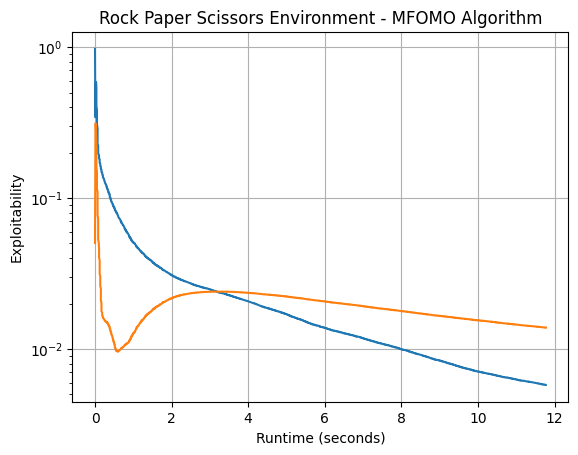

In [ ]:
env_instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
solns, solns_mu, expls, diffs, runtimes = TwoScaleLearning().solve(env_instance, max_iter=5000, verbose=True)

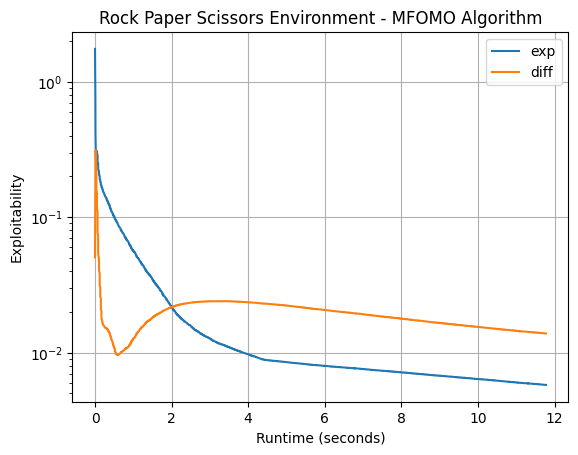

In [7]:
plt.semilogy(runtimes, expls, label='exp') 
plt.semilogy(runtimes, diffs, label='diff') 
plt.legend()
plt.grid(True)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Exploitability")
plt.title("Rock Paper Scissors Environment - MFOMO Algorithm")
plt.show()

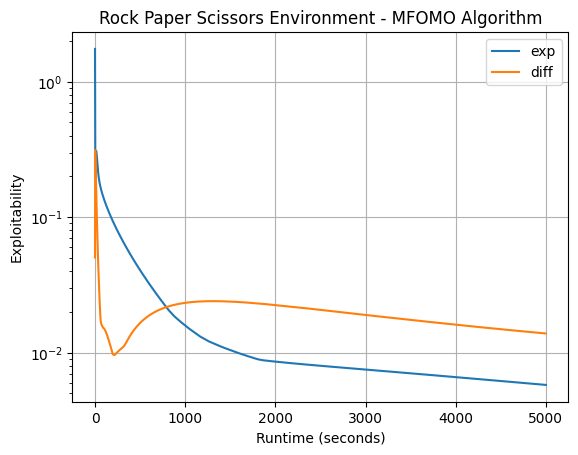

In [8]:
plt.semilogy(expls, label='exp') 
plt.semilogy(diffs, label='diff') 
plt.legend()
plt.grid(True)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Exploitability")
plt.title("Rock Paper Scissors Environment - MFOMO Algorithm")
plt.show()

### Two-scale based on FP

In [18]:
env_instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
diff_record = []
exp_record = []
S = env_instance.S
A = env_instance.A

# Auxiliary variables
l_s = len(S)
l_a = len(A)
n_a = tuple_prod(A)
ones_ts = (1,) * (1 + l_s)
ats_to_tsa = tuple(range(l_a, l_a + 1 + l_s)) + tuple(range(l_a))

pi = "uniform"
pi = _ensure_free_tensor(pi, env_instance)


for i in range(2000):
    print(f'iter = {i}')
    L = mean_field(env_instance, pi)
    pi_br = Greedy_Policy(env_instance, L)
    L_br = mean_field(env_instance, pi_br)
    mu_rptd = (
        L.flatten(start_dim=1 + l_s)
        .sum(-1)
        .repeat(A + ones_ts)
        .permute(ats_to_tsa)
    )
    mu_br_rptd = (
        L_br.flatten(start_dim=1 + l_s)
        .sum(-1)
        .repeat(A + ones_ts)
        .permute(ats_to_tsa)
    )

    mu0 = mu[0]
    muN = mu[-1]
    
    weight_mu = 1 / (i+1) ** 0.6
    new_mu0 = (1-weight_mu) * mu0 + weight_mu * muN
    new_mu0 /= torch.sum(new_mu0)
    env_instance.update_initial_distribution(new_mu0)


    weight_pi = 1 / (i+1) ** 1

    pi_next_num = (1 - weight_pi) * pi.mul(mu_rptd) + weight_pi * pi_br.mul(
        mu_br_rptd
    )
    pi_next_den = (1 - weight_pi) * mu_rptd + weight_pi * mu_br_rptd
    pi = pi_next_num.div(pi_next_den).nan_to_num(
        nan=1 / n_a, posinf=1 / n_a, neginf=1 / n_a
    )  


    L = mean_field(env_instance, pi)
    mu = torch.sum(L, axis=2)
    # now pi should induce mu from mu_N
    diff = cal_diff(mu[0], mu[-1])
    print(f'for self-consistent pair, diff = {diff}')
    exp = exploitability_score(env_instance, pi)
    print(f'for self-consistent pair, exp = {exp}')
    exp_record.append(exp)


torch.Size([10, 3])
iter = 0
for self-consistent pair, diff = 0.08653926104307175
for self-consistent pair, exp = 5.457280158996582
iter = 1
for self-consistent pair, diff = 0.03615812212228775
for self-consistent pair, exp = 1.3865342140197754
iter = 2
for self-consistent pair, diff = 0.04707660153508186
for self-consistent pair, exp = 1.0233707427978516
iter = 3
for self-consistent pair, diff = 0.013416197150945663
for self-consistent pair, exp = 0.6157951354980469
iter = 4
for self-consistent pair, diff = 0.0009735106723383069
for self-consistent pair, exp = 0.36965465545654297
iter = 5
for self-consistent pair, diff = 0.0016916380263864994
for self-consistent pair, exp = 0.25702524185180664
iter = 6
for self-consistent pair, diff = 0.001446654205210507
for self-consistent pair, exp = 0.1849827766418457
iter = 7
for self-consistent pair, diff = 0.0014338073087856174
for self-consistent pair, exp = 0.1351337432861328
iter = 8
for self-consistent pair, diff = 0.0012363980058580637
for

### Two-scale based OMD

In [54]:
env_instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
diff_record = []
exp_record = []
S = env_instance.S
A = env_instance.A

# Auxiliary variables
T = env_instance.T
S = env_instance.S
A = env_instance.A

y = torch.zeros((T + 1,) + S + A)

# Auxiliary functions
soft_max = torch.nn.Softmax(dim=-1)

# Auxiliary variables
l_s = len(S)

pi = "uniform"
pi = _ensure_free_tensor(pi, env_instance)
max_iter = 20000

Q_speed = 0.6
mu_speed = 1

for i in range(max_iter):
    print(f'iter = {i}')
    L = mean_field(env_instance, pi)
    mu = torch.sum(L, axis=2)
    Q = QFn(env_instance, L, verify_integrity=False).for_policy(pi)
    weight_Q = 1 / (i+1) **  Q_speed
    y += weight_Q * Q
    
    weight_mu = 1 / (i+1) ** mu_speed
    new_mu0 = (1-weight_mu) * mu[0] + weight_mu * mu[-1]
    new_mu0 /= torch.sum(new_mu0)
    env_instance.update_initial_distribution(new_mu0)
    
    
    pi = cast(
        torch.Tensor,
        soft_max(y.flatten(start_dim=1 + l_s)).reshape((T + 1,) + S + A),
    )

    L = mean_field(env_instance, pi)
    mu = torch.sum(L, axis=2)
    # now pi should induce mu from mu_N
    diff = cal_diff(mu[0], mu[-1])
    print(f'for self-consistent pair, diff = {diff}')
    exp = exploitability_score(env_instance, pi)
    print(f'for self-consistent pair, exp = {exp}')
    diff_record.append(diff)
    exp_record.append(exp)


torch.Size([10, 3])
iter = 0
for self-consistent pair, diff = 0.36605262756347656
for self-consistent pair, exp = 0.4840073585510254
iter = 1
for self-consistent pair, diff = 0.3438337445259094
for self-consistent pair, exp = 0.25552797317504883
iter = 2
for self-consistent pair, diff = 0.2942628264427185
for self-consistent pair, exp = 0.2977299690246582
iter = 3
for self-consistent pair, diff = 0.2510450780391693
for self-consistent pair, exp = 0.3589468002319336
iter = 4
for self-consistent pair, diff = 0.21501483023166656
for self-consistent pair, exp = 0.39807701110839844
iter = 5
for self-consistent pair, diff = 0.185166597366333
for self-consistent pair, exp = 0.4180173873901367
iter = 6
for self-consistent pair, diff = 0.1602506935596466
for self-consistent pair, exp = 0.4232468605041504
iter = 7
for self-consistent pair, diff = 0.13925662636756897
for self-consistent pair, exp = 0.417447566986084
iter = 8
for self-consistent pair, diff = 0.12141425162553787
for self-consistent

In [ ]:
env_instance = Environment.beach_bar(n=10, bar_loc=5, T=3)


tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor([[0.0437, 0.0486, 0.0608, 0.0958, 0.1660, 0.2102, 0.1663, 0.0962, 0.0615,
         0.0508],
        [0.0412, 0.0465, 0.0570, 0.0868, 0.1726, 0.2314, 0.1731, 0.0870, 0.0576,
         0.0470],
        [0.0424, 0.0476, 0.0567, 0.0872, 0.1711, 0.2297, 0.1715, 0.0877, 0.0573,
         0.0488],
        [0.0437, 0.0486, 0.0608, 0.0957, 0.1660, 0.2102, 0.1663, 0.0962, 0.0615,
         0.0509]])


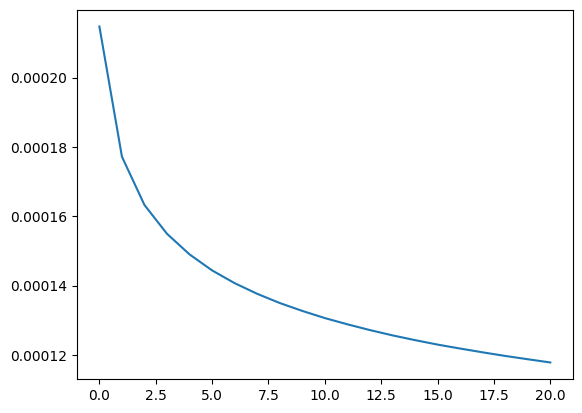

In [60]:
L = mean_field(env_instance, pi)
mu = torch.sum(L, axis=2)
diff = cal_diff(mu[0], mu[-1])
diff_record = [diff]
for i in range(20):
    weight_mu = 1 / (i+1) ** mu_speed
    new_mu0 = (1-weight_mu) * mu[0] + weight_mu * mu[-1]
    new_mu0 /= torch.sum(new_mu0)
    env_instance.update_initial_distribution(new_mu0)
    L = mean_field(env_instance, pi)
    mu = torch.sum(L, axis=2)
    diff = cal_diff(mu[0], mu[-1])
    print(diff)
    diff_record.append(diff)
plt.plot(diff_record)
print(mu)

[0.4840073585510254, 0.25552797317504883, 0.2977299690246582, 0.3589468002319336, 0.39807701110839844, 0.4180173873901367, 0.4232468605041504, 0.417447566986084, 0.40514421463012695, 0.3893465995788574, 0.3728365898132324, 0.35647058486938477, 0.34000730514526367, 0.3238058090209961, 0.30831050872802734, 0.2944064140319824, 0.28122615814208984, 0.27010488510131836, 0.2606945037841797, 0.25252866744995117, 0.24482154846191406, 0.23755455017089844, 0.23070001602172852, 0.2244725227355957, 0.21896028518676758, 0.21373987197875977, 0.20879030227661133, 0.2046675682067871, 0.20085954666137695, 0.1972370147705078, 0.19401884078979492, 0.19142627716064453, 0.18895435333251953, 0.18659305572509766, 0.18433523178100586, 0.18217182159423828, 0.1800980567932129, 0.1782231330871582, 0.17667531967163086, 0.17518329620361328, 0.17373991012573242, 0.17234420776367188, 0.1709904670715332, 0.169677734375, 0.16840410232543945, 0.16716480255126953, 0.16595840454101562, 0.16478443145751953, 0.163639068603

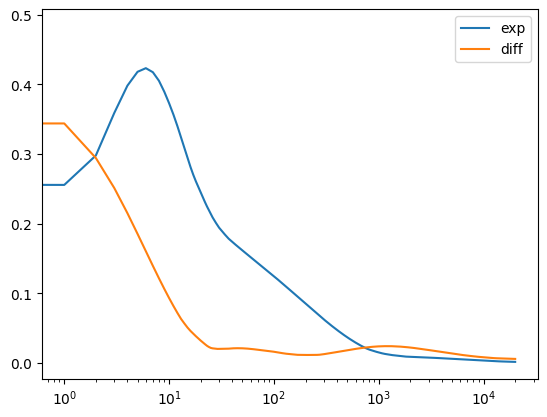

In [55]:
print(exp_record)
plt.plot(exp_record, label='exp')
plt.plot(diff_record, label='diff')
plt.xscale('log')
plt.legend()
L = mean_field(env_instance, pi)
mu = torch.sum(L, axis=2)
print(mu)